<img 
    style="position: absolute; 
           left: 60%; 
           top: 0; /* Added to ensure proper positioning */
           height: 900px; 
           width: 40%; /* Maintain the original width */
           object-fit: cover; /* Adjust if necessary */
           clip-path: inset(0px 50px 0px 50px round 10px);" 
    src="https://www.mathworks.com/help/examples/stats/win64/ParellelBayeianOptimizationExample_01.png" 
/>

</figure>


<h1 style="width: 60%; color: Orange; font-size: 40pt;">
    <Strong>
        CEGM2003 project: Bayesian optimization for truss structures
    </Strong>
</h1>

<h2 id="Background"><B>
    Background<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>
<p style="text-align: justify; width: 60%; font-weight: normal;">
     Structures that make optimal use of the material they are made of reduces the cost and environmental impact of their construction as the amount of material required. Optimization of structural design is a challenging task because of the high number of design parameters and the relatively expensive evaluation of the suitability of any given design. Standard optimization techniques in high-dimensional design space require a very large number of possible designs that need to be evaluated. In structural analysis, where evaluating the objective function and checking the constraints involves the solution of a structural mechanics problem, e.g. with finite elements, this quickly becomes very expensive, even if the model is relatively simple from structural point of view. Bayesian optimization is a machine-learning-based optimization technique that aims to reduce the number of evaluations of the objective function through data-driven exploration of the design space with a probabilistic surrogate.
</p>

<h2 id="Background"><B>
    Objective & Description<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>

<div style="width: 60%; border-top: 4px solid #34D058; border-left: 4px solid #34D058; background-color: #F6FFED; padding: 1em 1em 1em 1em; color: #24292E; margin: 10px 0 20px 0; box-sizing: border-box;">
    <div style="background-color: #34D058; color: white; padding: 0.2em 1em; margin: -1em -1em 0em -1em; font-size: 1.2em;"><strong>Project Objective</strong></div>
    <p><strong>The aim of this project is to find an optimal truss design,</strong><br>
    this will be achieved by finding an optimal set of nodal coordinates and cross-sectional properties. The primary objective is to minimize the total weight of the structure, while satisfying structural requirements. Optionally, additional objectives can be included, e.g. on the minimization of cutoff waste when reusing components from an existing inventory of elements.</p>
</div>

## <strong> X | Imports</strong>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import sys
import io
import os

from botorch.utils.transforms import normalize
from botorch.utils.transforms import unnormalize
from tabulate import tabulate
from contextlib import redirect_stdout
from sklearn.preprocessing import MinMaxScaler

sys.path.append('../pyJive/')
from utils import proputils as pu
from names import GlobNames as gn
import main

In [2]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## <strong> X | Classes & Dependencies</strong>

In [3]:
class TRUSS():
    def __init__(self, file_path, file_name, output_path, write_name, violation_penalty, scalers, bounds, lower_area=4e-3, freq_constraints=[20, 40, 60], mass_weight=1, freq_weight=1):
        # Configuration Parameters
        self.config = {
            "read_file_path": file_path,
            "read_file_name": file_name,
            "write_file_path": output_path,
            "write_file_name": write_name,
            "violation_penalty": violation_penalty,
            "scalers": {"y": scalers[0], "a": scalers[1]},
            "lower_area": lower_area,
            "bounds" : bounds,
            "freq_constraints": freq_constraints,
            "mass_weight": mass_weight,
            "freq_weight": freq_weight,
            "density": 7850,  # kg/m^3 As per Garnachos
        }

        self.state = {
            "nodes": {},
            "connectivity": None,
            "member_df": None,
            "y_coordinates": None,
            "x_coordinates": None,
            "cross_sections": None,
            "lengths": None,
            "mass_norm": 360,
            "monitor_df": None
        }

        self.columns = ["Metric", "Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Constraint Violation (Loss No W)"]
        self.state["monitor_df"] = pd.DataFrame(columns=self.columns)
    # -------------------------- Import & Writing Files -------------------------- #
    def read_geom_file(self):
        path = os.path.normpath(os.path.join(self.config["read_file_path"], self.config["read_file_name"]))
        with open(path, 'r') as file:
            lines = file.readlines()

        nodes = {}
        members = []
        section = None

        for line in lines:
            line = line.strip()
            if line.startswith('node:'):
                section = 'node'
            elif line.startswith('member:'):
                section = 'member'
            else:
                if section == 'node' and line:
                    parts = line.split()
                    node_number = int(parts[0])
                    node_data = tuple(map(float, parts[1:]))
                    nodes[node_number] = node_data
                elif section == 'member' and line:
                    member_data = tuple(map(int, line.split()))
                    members.append(member_data)

        self.state["nodes"] = nodes
        self.state["member_df"] = pd.DataFrame(members, columns=['Node #1', 'Node #2', 'Number of Elements', 'Cross-section Type'])

        connectivity = self.state["member_df"].to_numpy()
        self.state["connectivity"] = connectivity[:, :2]
        self.state["y_coordinates"] = np.array([value[1] for _, value in nodes.items()])
        self.state["x_coordinates"] = np.array([value[0] for _, value in nodes.items()])

    def get_write_geom_file(self,path_,write_file): 
        path = os.path.normpath(os.path.join(path_,write_file))
        file = open(path)

        for i, (x, _) in self.state["nodes"].items():
            self.state["nodes"][i] = (x, self.state["y_coordinates"][i])

        geom = 'node: node #, x-coordinate; y-coordinate\n'
        for node_num, coords in self.state["nodes"].items():
            geom += f"{node_num} {' '.join(map(str, coords))}\n"
        
        connectivity = self.state["member_df"].to_numpy()
        geom += '\nmember: Node #1; Node #2; number of elements; cross-section type\n'
        for row in connectivity:
            geom += ' '.join(map(str, row)) + '\n'

        output_file_path = os.path.normpath(os.path.join(path_,'TRUSS.geom'))
        with open(output_file_path, 'w') as file:
            file.write(geom)
            
        return file.name
    
    def fit_scalers(self, initial_data):
        y_data = initial_data[:5].reshape(1, -1).T
        a_data = initial_data[5:].reshape(1, -1).T
        self.config["scalers"]["y"].fit(y_data)
        self.config["scalers"]["a"].fit(a_data)

    def scaler(self, mode, x_values, scaler_type):
        scaler = self.config["scalers"][scaler_type]
        x_values = x_values.reshape(1, -1).T
        if mode == 'scale':
            scaled_values = scaler.transform(x_values)
        elif mode == 'descale':
            scaled_values = scaler.inverse_transform(x_values)
        return scaled_values.flatten()
    
    def areas_coordinates_write_split(self, x_list):        
        y_coordinates = np.copy(self.state["y_coordinates"])  # Use a copy to avoid modifying the original array directly
        areas = x_list[5:]
        y_coords = x_list[:5]
        for i, y in enumerate(y_coords, start=1):
            y_coordinates[2 * i] = y
            y_coordinates[20 - 2 * i] = y

        self.state["y_coordinates"] = y_coordinates  # Update state

        return areas, y_coords
    # ---------------------------------------------------------------------------- #
    #                                TARGET FUNCTION                               #
    # ---------------------------------------------------------------------------- #
    def loss_function(self, x_list):
        """
        Calculate the loss for a given set of design parameters.
        Parameters:
        x_list (list): A list of design parameters.
        Returns:
        float: The calculated loss based on mass, frequency constraints, and imaginary penalties.
        """
        if isinstance(x_list,torch.Tensor):
            x_list = x_list.detach().cpu().numpy().flatten()
            self.temporary = x_list
        
        A_list, y_list = self.areas_coordinates_write_split(x_list)
        mass_truss = self.mass_truss(A_list, y_list)
        freq1, freq2, freq3 = self.eigenfrequencies(A_list)
        frequencies = np.array([freq1, freq2, freq3])

        freq_penalty = 0
        all_positive = True
        for f, t in zip(frequencies, self.config["freq_constraints"]):
            diff = f - t
            penalty_factor = 1 if diff >= 0 else self.config["violation_penalty"]
            freq_penalty += penalty_factor * (np.abs(diff) / t)
            if diff < 0:
                all_positive = False
        
        if all_positive:
            self.state["mass_norm"] = min(mass_truss, self.state["mass_norm"])

        normalized_mass_penalty = (mass_truss - self.state["mass_norm"]) / self.state["mass_norm"]
        normalized_freq_penalty = freq_penalty / len(self.config["freq_constraints"])
        constraint_violation = normalized_freq_penalty + normalized_mass_penalty

        LOSS = (self.config["mass_weight"] * normalized_mass_penalty +
                self.config["freq_weight"] * normalized_freq_penalty)
        # -------------------------- Optimisation monitoring ------------------------- #
        optmonitor_data = [
            ["Metric","Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Constraint Violation (Loss No W)"],
            ["Value",LOSS, frequencies, mass_truss, normalized_mass_penalty, normalized_freq_penalty, constraint_violation]
        ]
        print(f'{tabulate(optmonitor_data, headers="firstrow", tablefmt="grid")}\n')
        
        row_data = optmonitor_data[1][0:]
        new_data = pd.DataFrame([row_data], columns=self.columns)
        self.state["monitor_df"] = pd.concat([self.state["monitor_df"], new_data], ignore_index=True)

        return LOSS

    # ----------------------------- SUPPORT FUNCTIONS ---------------------------- #
    def eigenfrequencies(self,A_list):
        path = os.path.normpath(os.path.join(self.config["read_file_path"], 'bridge_frequency.pro'))
        
        props = pu.parse_file(path)
        props['model']['truss']['area'] = A_list
        props['init']['mesh']['file'] = self.get_write_geom_file(self.config["write_file_path"], self.config["write_file_name"])
        
        trap = io.StringIO()
        with redirect_stdout(trap):
            globdat = main.jive(props)
        
        return (globdat[gn.EIGENFREQS][0:3] / 2 / np.pi)

    def mass_truss(self,areas, y_list):
        x_coordinates = self.state["x_coordinates"]
        y_coordinates = self.state["y_coordinates"]
        
        for i, y in enumerate(y_list, start=1):
            y_coordinates[2 * i] = y
            y_coordinates[20 - 2 * i] = y

        coordinates = list(zip(x_coordinates, y_coordinates))
        lengths = np.zeros(len(self.state["connectivity"]))
        for i, (node1, node2) in enumerate(self.state["connectivity"]):
            x1, y1 = coordinates[node1]  # Adjusting index to start from 0
            x2, y2 = coordinates[node2]
            lengths[i] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        n_elements = self.state["member_df"].iloc[:,2].sum()
        areas_i = np.zeros(n_elements)
        cross_section_number = self.state["member_df"].iloc[:,-1] 
        
        for i,item in enumerate(cross_section_number):
                areas_i[i] = areas[item]
        self.temporary = areas_i
        self.state["cross_sections"] = areas[:15]
        self.state["lengths"] = lengths

        volumes = lengths * areas_i
        total_volume = np.sum(volumes)
        dens = 7800
        mass = total_volume * dens

        return mass
    # ----------------------------------- OTHER ---------------------------------- #
    def Initial_guess(self, optim_dims):
        sampled_points = np.zeros(len(optim_dims))
        for i, dim_index in enumerate(optim_dims):
            lower_bound, upper_bound = bounds[i]
            sampled_points[i] = np.random.uniform(lower_bound, upper_bound)
        return sampled_points


In [4]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, batch_size, bounds):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.bounds = bounds
        self.boundsmm = [(0,1),(0,1)] # Bounds consistent with Minmax scaling 
        self.x_bounds = [self.boundsmm[0]] * 5 + [self.boundsmm[1]] * 15 
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        self.uncertainty = []
        self.y_loss = []
        
        matern_length_scale_bounds = (1e-3, 1e5)
        initial_length_scale = np.ones(20)
        kernel = ConstantKernel(1.0) * Matern(length_scale=initial_length_scale, length_scale_bounds=matern_length_scale_bounds, nu=0.5)
        self.gauss_pr =  GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
    
    def estimate_uncertainty(self, n=10):
        sampled_points = []
        uncertainties = []
        for _ in range(100):  # Sample 100 times
                x_start = self.next_guess()  # Random starting point for exploration 
                x_start_sc = self.scaler(x_start, 'scale')       

                y, cov = self.gauss_pr.predict(np.array(x_start_sc).reshape(1, -1), return_std=True)
                sampled_points.append(x_start_sc)
                uncertainties.append(cov[0])  # We use the standard deviation (uncertainty)

        uncertainties = np.array(uncertainties)
        sampled_points = np.array(sampled_points)
        sorted_indices = np.argsort(-uncertainties)
        top_n_points = sampled_points[sorted_indices[:n]]

        return top_n_points
        
    def _get_expected_improvement(self, x_new):
        '''
        Calculates the expected improvement at a given point x_new
        '''
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array(x_new).reshape(1, -1), return_std=True)
        if sigma_y_new[0] == 0.0:
            return 0.0
        
        min_mean_y = self.y_min
        z = (min_mean_y - mean_y_new) / sigma_y_new        
        exp_imp = (min_mean_y - mean_y_new) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        return exp_imp
  
    def _get_next_probable_point(self):
        '''
        We only standardise the data after the minimisation so the LOSS FUNCTION operates with standard scales
        ### FIX , Before We were only returning if better this does not allow the gaussian process to understand the data as well
        '''
        x_optimal = None
        x_next_sc = None
        max_acq_value = float('inf')

        for _ in range(self.batch_size):
            x_start_sc = self.estimate_uncertainty(self, n=10)
            res = minimize(fun=self._acquisition_function, x0=x_start_sc, bounds = self.x_bounds, method='L-BFGS-B')
            # --------------------------------- Normalise -------------------------------- #
            if res.fun < max_acq_value:
                max_acq_value = res.fun
                x_next_sc = res.x
                x_optimal = self.scaler(x_next_sc, 'descale')

        return x_optimal, x_next_sc, -max_acq_value  #Note: Negative min neg acq function
    
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array([y]), axis = 0)
  
    def optimize(self):
        """
        Performs optimization to minimize the target function using Gaussian Process Regression.

        Iteratively selects and evaluates new points based on the Expected Improvement (EI) criterion,
        updating the optimal point and minimum value found.

        Returns:
            optimal_x (np.ndarray): Optimal input values minimizing the target function.
            y_min (float): Minimum value of the target function observed.
        """
        # Initialize the Gaussian Process Regressor with the best guess
        y_min_ind = np.argmin(self.y_init)
        y_min = self.y_min = self.y_init[y_min_ind] 
        optimal_x = self.x_init[y_min_ind]
        optimal_ei = None

        if isinstance(self.y_init, list):
            self.y_init = np.array(self.y_init)
        
        for i in range(self.n_iter):
            print(f'Iteration: {i} Best loss = {y_min:.2f}\n')
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next ,x_next_sc, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array(x_next)) ## Call loss Function
            self._extend_prior_with_posterior_data(x_next_sc,y_next)
            if ((y_next < y_min) & (y_next > 0)):
                y_min = self.y_min = y_next
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                prev_x = x_next
            else:
                self.distances_.append(norm(prev_x - x_next))
                prev_x = x_next

            self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"x": [optimal_x],"y": [y_min], "ei": [optimal_ei]})), ignore_index=True) 
        return optimal_x, y_min

    def next_guess(self):
        y_bound = self.bounds[0]
        A_bound = self.bounds[1]
        y = np.random.uniform(y_bound[0], y_bound[1], 5)
        Areas = np.random.uniform(A_bound[0], A_bound[1], 15)
        x_list = np.append(y, Areas)
        return x_list
    
    def scaler(self, x, mode):
        y_coords = x[:5]
        y_coords_sc = SC_wrapper(mode, y_coords, 'y')
        areas = x[5:]
        areas_sc = SC_wrapper(mode, areas, 'a')
        x_out = np.concatenate([y_coords_sc, areas_sc])
        return x_out 

In [22]:
# ------------------------------ OTHER FUNCTIONS ----------------------------- #
def SC_wrapper(mode,x,scaler):
    return TRUSS1.scaler(mode,x, scaler)

def objective_function(x):
    return TRUSS1.loss_function(x)

def final_results(OBJECT, best_x):
    # Read the input file and store in props object
    areas ,y_coords = OBJECT.areas_coordinates_write_split(best_x)
    mass = OBJECT.mass_truss(areas, y_coords)
    path_wr = OBJECT.get_write_geom_file(OBJECT.config["write_file_path"], 'TRUSS.geom')

    path = os.path.normpath(os.path.join(OBJECT.config["write_file_path"],'bridge_frequency_truss.pro'))
    props = pu.parse_file(path)
    props['model']['truss']['area'] = OBJECT.state["cross_sections"]
    print(OBJECT.state["cross_sections"])
    props['init']['mesh']['file'] = path_wr
    # Call the program and store output in globdat
    trap = io.StringIO()
    with redirect_stdout(trap):
        globdat = main.jive(props)
    print((globdat[gn.EIGENFREQS][0:3] / 2 / np.pi))

# <strong> Default</strong>

## <strong> 1 | Initialisation</strong>

In [105]:
# -------------------------------- Definitions ------------------------------- #
read_file_path = '../truss_bridge/data'
read_file = 'bridge.geom'
write_file_path =  '../truss_bridge/data/@TRUSS'
write_file = 'TRUSS.geom'

optim_dims = [i for i in range(20)]  
lower_area = 40e-4
violation_factor = 10
freq_constraints = [20,40,60]
mass_weight = 2
freq_weight = 5
A_bound = (0.0001, 0.01)
y_bound = (0.5, 2)

scalers = [MinMaxScaler(),MinMaxScaler()] # [y_scaler, a_scaler]
AL_bound = (lower_area - A_bound[0], lower_area + A_bound[0])
bounds = np.array([y_bound if index <= 4 else A_bound for index in optim_dims])
bounds[5] = AL_bound

TRUSS1= TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSS1.read_geom_file()

In [106]:
# -------------------------------- Initiation -------------------------------- #
n_samples =  10

x_list = []
y_list = []
x_list_sc = []
x_0 = np.empty(len(optim_dims))

for _ in range(n_samples):
    x_c = np.copy(x_0) # Reset seed
    x_random = TRUSS1.Initial_guess(optim_dims)
    x_c[optim_dims] = x_random
    x_list.append(x_c)
# 
trap = io.StringIO()
with redirect_stdout(trap):
    for x in x_list:
        LOSS = TRUSS1.loss_function(x)
        y_list.append(LOSS)
# 
# ---------------------------- INITIATE OPTIMISER ---------------------------- #
bounds = torch.tensor(bounds.T)
X_SAAS = torch.tensor(np.array(x_list))
X_init_norm = normalize(X_SAAS, bounds=bounds)  
y_init_t = torch.tensor(y_list).reshape(-1,1)

C:\Users\javie\AppData\Local\Temp\ipykernel_24224\1520782791.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.state["monitor_df"] = pd.concat([self.state["monitor_df"], new_data], ignore_index=True)


## <strong> 2 | Optimisation </strong>

### <strong> 2.0 | Botorch Imports </strong>

In [7]:
from botorch.models import SingleTaskGP
from botorch.models import SaasFullyBayesianSingleTaskGP

from botorch.fit import fit_gpytorch_model
from botorch.fit import fit_fully_bayesian_model_nuts

from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood

from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

### <strong> 2.1 | Single task Optimisation </strong>

Best performing algorithm although it does not have a as strong probabilistic interpretation as the SAAS model for this dimension space it converges to a solution faster. The algorithm coverges faster to a solution with smaller batch sizes this is potentially since the bounds and constraints introduced are already quite small and the solution spaces in between and in these are relatively proportional.

In [56]:
def SingleBOPT(Y_init_single, X_init_single, n_iter, batch_size, Nrestats):
    gp_model = SingleTaskGP(X_init_single, Y_init_single)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)
    
    for iteration in range(n_iter):
        print(f'Iteration: {iteration} Best loss = {Y_init_single.min().item():.2f}\n')
        acq_func = ExpectedImprovement(model=gp_model, best_f=Y_init_single.min(), maximize=False)
        new_x, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,
            num_restarts= Nrestats,
            raw_samples= batch_size,
        )
        new_x_unnorm = unnormalize(new_x, bounds=bounds)
        new_y = objective_function(new_x_unnorm)
        new_y = torch.tensor(new_y, dtype=torch.float32).reshape(1,-1)
        X_init_single = torch.cat([X_init_single, new_x])
        Y_init_single = torch.cat([Y_init_single, new_y])
        
        gp_model.set_train_data(inputs=X_init_single, targets=Y_init_single.flatten(), strict=False)
        fit_gpytorch_model(mll)
    return X_init_single, Y_init_single

In [81]:
Y_init_single , X_init_single = y_init_t, X_init_norm
n_iter = 350
batch_size = 10
Nrestats = 10

X_init_single , Y_init_single = SingleBOPT(Y_init_single, X_init_single, n_iter, batch_size, Nrestats)

c:\Users\javie\Documents\@JF\JF\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([17.2373], dtype=torch.float64), std = tensor([6.2822], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 0 Best loss = 8.85

+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+
| Metric   |   Total Loss | Natural Frequencies                   |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation (Loss No W) |
+==========+==============+=======================================+=================+========================+=====================+====================================+
| Value    |      12.5793 | [ 9.70093952 33.9072485  54.98773675] |         371.847 |              0.0329085 |              2.5027 |                            2.53561 |
+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+

Iteration: 1 Best loss = 8.85

+----------+--------------+---------------------------------------+-----------------+--

### <strong> 2.2 | SAAS Optimisation </strong>

- Exhibits worst performance, this is in part expected since in our problem there is not bayesian interpretation to data due to objective function.

In [62]:
def SAASBOPT(Y_SAAS, X_SAAS, n_iter, batch_size, Nrestats,n_samples,fit_interval):
    gp_model = SaasFullyBayesianSingleTaskGP(X_SAAS, Y_SAAS)
    gp_model.likelihood = GaussianLikelihood()
    fit_fully_bayesian_model_nuts(gp_model)

    for iteration in range(n_iter):
        print(f'Iteration: {iteration} Best loss = {Y_SAAS.min().item():.2f}')
        acq_func = ExpectedImprovement(model=gp_model, best_f=Y_SAAS.min(), maximize=False)
        new_x, _ = optimize_acqf(
                    acq_function= acq_func,
                    bounds= bounds,
                    q=1,
                    num_restarts= Nrestats,
                    raw_samples= batch_size,
                )

        new_x_unnorm = unnormalize(new_x, bounds=bounds)
        new_y = objective_function(new_x_unnorm)
        new_y = torch.tensor(new_y, dtype=torch.float32).reshape(1,-1)
        
        X_SAAS = torch.cat([X_SAAS, new_x])
        Y_SAAS = torch.cat([Y_SAAS, new_y])

        if iteration % fit_interval == 0:
            fit_fully_bayesian_model_nuts(gp_model)    

    return X_SAAS, Y_SAAS

In [439]:
Y_init_saas , X_init_saas = y_init_t, X_init_norm
fit_interval = 10
n_iter = 10
batch_size = 20
Nrestats = 10

X_SAAS ,Y_SAAS = SAASBOPT(Y_init_saas, X_init_saas, n_iter, batch_size, Nrestats, n_samples, fit_interval)

Warmup:   0%|          | 0/768 [00:00, ?it/s]

Sample: 100%|██████████| 768/768 [04:06,  3.12it/s, step size=2.71e-01, acc. prob=0.882]


Iteration: 0 Best loss = 14.15
+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+
| Metric   |   Total Loss | Natural Frequencies                   |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation (Loss No W) |
+==========+==============+=======================================+=================+========================+=====================+====================================+
| Value    |      30.9425 | [13.8596885  27.9771443  40.87028067] |         365.581 |               0.015504 |             3.08805 |                            3.10356 |
+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+



Sample: 100%|██████████| 768/768 [03:41,  3.46it/s, step size=2.52e-01, acc. prob=0.916]


Iteration: 1 Best loss = 14.15
+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+
| Metric   |   Total Loss | Natural Frequencies                   |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation (Loss No W) |
+==========+==============+=======================================+=================+========================+=====================+====================================+
| Value    |      30.2987 | [14.27452027 27.65556036 41.37824212] |         371.144 |               0.030955 |             3.01749 |                            3.04845 |
+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+

Iteration: 2 Best loss = 14.15
+----------+--------------+---------------------------------------+-----------------+--

### <strong> 2.3 | Save Data </strong>

In [ ]:
# --------------------------------- SAVE DATA -------------------------------- #
file_name = "TRUSS1_bopt_data.pkl"

data_single = {
    "Y_init_single": Y_init_single,
    "X_init_single": X_init_single,
    "n_iter": n_iter,
    "batch_size": batch_size,
    "Nrestats": Nrestats,
    "X_single": X_init_single,
    "Y_single": Y_init_single
}
data_SAAS = {
    "Y_init_single": Y_init_saas,
    "X_init_single": X_init_saas,
    "n_iter": n_iter,
    "batch_size": batch_size,
    "Nrestats": Nrestats,
    "X_SAAS": X_SAAS,
    "Y_SAAS": Y_SAAS
}
data_to_save = [data_single, data_SAAS]

with open(file_name, 'wb') as file:
    pickle.dump(data_to_save, file)

In [183]:
file_name = "TRUSS1_bopt_data.pkl"
path_s = os.path.normpath(os.path.join(write_file_path, file_name))
with open(path_s, 'rb') as file:
    loaded_data = pickle.load(file)

data_single = loaded_data[0]
data_SAAS = loaded_data[1]

Y_init_single = data_single["Y_init_single"]
X_init_single = data_single["X_init_single"]
n_iter = data_single["n_iter"]
batch_size = data_single["batch_size"]
Nrestats = data_single["Nrestats"]
X_init_single = data_single["X_single"]
Y_init_single = data_single["Y_single"]

Y_init_SAAS = data_SAAS["Y_init_single"]
X_init_SAAS = data_SAAS["X_init_single"]
n_iter = data_SAAS["n_iter"]
batch_size = data_SAAS["batch_size"]
Nrestats = data_SAAS["Nrestats"]
X_SAAS = data_SAAS["X_SAAS"]
Y_SAAS = data_SAAS["Y_SAAS"]

## <strong> 3 | Results </strong>

### <strong> 3.1 | TRUSS Run </strong>

### <strong> 3.2 | Variance in solution paths </strong>

In [178]:
num_runs = 5
n_iter_comparison = 50
results_single = np.zeros((num_runs, n_iter_comparison))
Y_init_bpt , X_init_bpt = y_init_t, X_init_norm

for i in range(num_runs):
    _, Y_init_p = SingleBOPT(Y_init_bpt, X_init_bpt, n_iter_comparison, batch_size, Nrestats)
    results_single[i, :] = Y_init_p[n_samples:].flatten()
mean_single = np.mean(results_single, axis=0)
std_single = np.std(results_single, axis=0)

c:\Users\javie\Documents\@JF\JF\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([13.8065], dtype=torch.float64), std = tensor([4.4957], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 0 Best loss = 8.59

+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+
| Metric   |   Total Loss | Natural Frequencies                   |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation (Loss No W) |
+==========+==============+=======================================+=================+========================+=====================+====================================+
| Value    |      23.6852 | [ 5.76433998 21.66040257 45.11811573] |         368.425 |              0.0234021 |             4.72768 |                            4.75108 |
+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+

Iteration: 1 Best loss = 8.59

+----------+--------------+---------------------------------------+-----------------+--

c:\Users\javie\Documents\@JF\JF\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([13.8065], dtype=torch.float64), std = tensor([4.4957], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 1 Best loss = 8.59

+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+
| Metric   |   Total Loss | Natural Frequencies                   |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation (Loss No W) |
+==========+==============+=======================================+=================+========================+=====================+====================================+
| Value    |       9.5453 | [ 9.7499339  37.64731433 60.8808565 ] |         359.789 |           -0.000585745 |              1.9093 |                            1.90871 |
+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+

Iteration: 2 Best loss = 8.59

+----------+--------------+---------------------------------------+-----------------+--

c:\Users\javie\Documents\@JF\JF\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([13.8065], dtype=torch.float64), std = tensor([4.4957], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 0 Best loss = 8.59

+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+
| Metric   |   Total Loss | Natural Frequencies                   |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation (Loss No W) |
+==========+==============+=======================================+=================+========================+=====================+====================================+
| Value    |      11.6538 | [ 9.18211596 36.35186403 55.85877319] |         354.335 |             -0.0157365 |             2.33706 |                            2.32132 |
+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+

Iteration: 1 Best loss = 8.59

+----------+--------------+---------------------------------------+-----------------+--

c:\Users\javie\Documents\@JF\JF\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([13.8065], dtype=torch.float64), std = tensor([4.4957], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 0 Best loss = 8.59

+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+
| Metric   |   Total Loss | Natural Frequencies                   |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation (Loss No W) |
+==========+==============+=======================================+=================+========================+=====================+====================================+
| Value    |      14.2363 | [ 7.72804943 30.61773025 62.94507379] |         363.342 |             0.00928439 |             2.84354 |                            2.85283 |
+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+

Iteration: 1 Best loss = 8.59

+----------+--------------+---------------------------------------+-----------------+--

c:\Users\javie\Documents\@JF\JF\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([13.8065], dtype=torch.float64), std = tensor([4.4957], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 0 Best loss = 8.59

+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+
| Metric   |   Total Loss | Natural Frequencies                   |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation (Loss No W) |
+==========+==============+=======================================+=================+========================+=====================+====================================+
| Value    |      8.88678 | [11.88689194 36.46025979 57.65618128] |         359.983 |           -4.63376e-05 |             1.77738 |                            1.77733 |
+----------+--------------+---------------------------------------+-----------------+------------------------+---------------------+------------------------------------+

Iteration: 1 Best loss = 8.59

+----------+--------------+---------------------------------------+-----------------+--

In [180]:
import altair as alt
import pandas as pd
import numpy as np

# Assuming results_single, mean_single, and std_single are already defined

iterations = np.arange(n_iter_comparison)
run_data = pd.DataFrame(results_single.T, columns=[f'Run {i+1}' for i in range(num_runs)])
run_data['Iteration'] = iterations
run_data = run_data.melt(id_vars=['Iteration'], var_name='Run', value_name='Loss')

# For individual runs, use a base color and vary the opacity to differentiate them
run_chart = alt.Chart(run_data).mark_line().encode(
    x='Iteration',
    y=alt.Y('Loss', title='Loss'),
    color=alt.value('lightblue'),  # Set a single base color for all runs
    opacity=alt.Opacity('Run:N', legend=None)  # Vary opacity by run to differentiate
)

# Preparing data for mean loss and confidence intervals
confidence_data = pd.DataFrame({
    'Iteration': iterations,
    'Lower Bound': mean_single - std_single,
    'Upper Bound': mean_single + std_single,
    'Optimizer': ['SingleBOPT Mean'] * len(mean_single)  # Renamed for clarity
})

simulation = pd.DataFrame({
    'Iteration': iterations,
    'Mean Loss': mean_single,
    'Optimizer': ['SingleBOPT Mean'] * len(mean_single)  # Use a distinct name for the mean line
})

# Plotting the mean loss with a dashed line
mean_loss_chart = alt.Chart(simulation).mark_line(strokeDash=[5,5]).encode(
    x='Iteration',
    y=alt.Y('Mean Loss', title='Mean Loss'),
    color=alt.value('black')  # Use a distinct color for the mean line
)

# Plotting confidence intervals
confidence_interval_chart = alt.Chart(confidence_data).mark_area(opacity=0.2, color='grey').encode(
    x='Iteration',
    y='Lower Bound',
    y2='Upper Bound'
)

# Combining the charts
final_chart = (run_chart + mean_loss_chart + confidence_interval_chart).properties(
    title="Optimization Runs with SingleBOPT Mean and Confidence Intervals",
    width=800,
    height=400
).interactive()

final_chart.display()  # If using Jupyter Notebook or similar environment


alt.LayerChart(...)















































































































## <strong> 4 | Benchmarking against Karnachos </strong>

### <strong> 4.1 | Final Trusses & Basic statistics </strong>

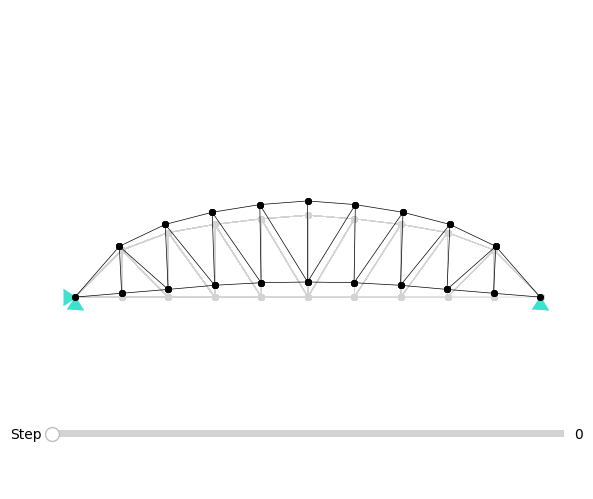

Smallest three natural frequencies:  [20.06682059 40.53905183 61.8225322 ]  Hz


360.07710670521664

In [184]:
#                      IMPORT AND INTIATE KANARCHOS BRIDGE                     #
# ---------------------------------------------------------------------------- #
path_pro = os.path.normpath(os.path.join(read_file_path, 'bridge_frequency_kr.pro'))
props = pu.parse_file(path_pro)

path_geom = os.path.normpath(os.path.join(read_file_path, 'bridge_kanarachos.geom'))
props['model']['truss']['area'] = [ 40e-4, 3.1997e-4, 1.0025e-4, 1.0000e-4, 2.5875e-4, 1.0895e-4, 1.1261e-4, 2.5624e-4, 1.4121e-4, 1.5758e-4, 2.2461e-4, 1.0694e-4, 1.3193e-4, 2.3846e-4, 1.0001e-4 ]
props['init']['mesh']['file'] = path_geom

trap = io.StringIO()
with redirect_stdout(trap):
    globdat = main.jive(props)
print('Smallest three natural frequencies: ', globdat[gn.EIGENFREQS][0:3]/2/np.pi, ' Hz')

# ------------------------ Initiate a Karnachos obect ------------------------ #
read_file_path = '../truss_bridge/data'
read_file = 'bridge_kanarachos.geom'
write_file_path =  None
write_file = None
violation_factor = None
freq_constraints = None
mass_weight = None
freq_weight = None
scalers = [None,None]
bounds = None

TRUSSKN= TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSSKN.read_geom_file()

y_coord = TRUSSKN.state["y_coordinates"][::2][1:6]
areas_kn = np.array(props['model']['truss']['area'])
TRUSSKN.mass_truss(areas_kn, y_coord)

In [187]:
# --------------------------- TRUSS1 Best solution --------------------------- #
mask = TRUSS1.state["monitor_df"]["Natural Frequencies"].apply(lambda x: (x >= freq_constraints).all())
ind = TRUSS1.state["monitor_df"][mask]["Mass of Truss"].idxmin()
min_mass_iter = TRUSS1.state["monitor_df"].iloc[ind]
best_x = unnormalize(X_init_single[ind], bounds=bounds)
final_results(TRUSS1, best_x)

TypeError: '>=' not supported between instances of 'float' and 'NoneType'

In [186]:
# ----------------------------------- Data ----------------------------------- #
TR_cs = TRUSS1.state["cross_sections"].numpy()
KN_cs = TRUSSKN.state["cross_sections"]

TR_m = TRUSS1.mass_truss(TR_cs, TRUSS1.state["y_coordinates"][::2][1:6])
KN_m = TRUSSKN.mass_truss(KN_cs, TRUSSKN.state["y_coordinates"][::2][1:6])

NFK = globdat[gn.EIGENFREQS][0:3]/2/np.pi
NFTR = TRUSS1.state["monitor_df"]["Natural Frequencies"][best_ind.numpy()]

data = {
    'Model': ['Kanarachos model', 'TRUSS model'],
    'Cross Section Average': [KN_cs.mean(), TR_cs.mean()],
    'Natural Frequency Average': [np.mean(NFTR), np.mean(NFK)],
    'Mass': [KN_m, TR_m]
}
basic_comp = pd.DataFrame(data)
basic_comp.set_index('Model', inplace=True)
basic_comp.index.name = None
basic_comp

NameError: name 'best_ind' is not defined

### <strong> 4.2 | Comparing benchmarks </strong>

In [380]:
max_cross_sections = max(np.max(TR_cs), np.max(KN_cs))
normalized_cross_sections_model1 = TR_cs / max_cross_sections
normalized_cross_sections_model2 = KN_cs / max_cross_sections

max_mass = max(TR_m, KN_m)
normalized_mass_model1 = TR_m / max_mass
normalized_mass_model2 = KN_m / max_mass

max_nat_freq = max(np.max(NFTR), np.max(NFK))
normalized_nat_freq_model1 = np.array(NFTR) / max_nat_freq
normalized_nat_freq_model2 = np.array(NFK) / max_nat_freq
# ------------------------------------ VIS ----------------------------------- #
data = {
    "Metric": ["Cross Sections (Mean)", "Mass", "Nat. Freq. 1", "Nat. Freq. 2", "Nat. Freq. 3"],
    "Model 1 (TRUSS1)": [np.mean(normalized_cross_sections_model1), normalized_mass_model1] + normalized_nat_freq_model1.tolist(),
    "Model 2 (TRUSSKN)": [np.mean(normalized_cross_sections_model2), normalized_mass_model2] + normalized_nat_freq_model2.tolist()
}
df = pd.DataFrame(data)

# Create a grouped bar chart for normalized cross sections, mass, and natural frequencies using plotly
barplot = px.bar(
    df,
    x='Metric',
    y=["Model 1 (TRUSS1)", "Model 2 (TRUSSKN)"],
    barmode='group',
    title='Comparison of Normalized Cross Sections, Mass, and Natural Frequencies',
    labels={'Metric': 'Metric', 'value': 'Normalized Value', 'variable': 'Model'},
    color_discrete_sequence=px.colors.qualitative.Set2  # Soft color palette
)
barplot.show()